In [2]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from scipy.stats import poisson

In [3]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024', '2022_2023', '2021_2022']
divisions = ['Premier League', 'Championship', 'Bundesliga', 'Serie A', 'La Liga', 'Ligue 1'] 
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Arsenal - Wolves,4fc9baf210346939946d5a49f255588b,Arsenal,31f3ecbc5c48590ccc7dabaedd49a4ff,Wolves,...,0.575835,14.0,2.0,7.769231,10.818182,1.18,7.50,13.00,2.75,1.44
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,ef393faadcf7d00912ef326a1cd0f103,Ligue 1,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-21,Marseille - Strasbourg,8377de0f1845174610bd8b815b9a285e,Marseille,c651bda18ca0a5704727ed63d2bd3e8b,Strasbourg,...,1.460000,9.0,5.0,9.850000,13.860000,2.05,3.60,3.60,2.10,1.72
8839,ef393faadcf7d00912ef326a1cd0f103,Ligue 1,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-21,Paris SG - Metz,541dd69b8e5c6a19f50d3dbf3819addf,Paris SG,a71f82f01730198a712591ceabb74238,Metz,...,0.690000,14.0,2.0,8.560000,18.400000,1.20,8.50,10.00,4.33,1.22
8840,ef393faadcf7d00912ef326a1cd0f103,Ligue 1,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-21,Angers - Montpellier,eeaba7c0c0cd90d3286ae34bf3131fc1,Angers,375c7d274d5b84410e7b2bf0a00a9465,Montpellier,...,1.300000,6.0,4.0,8.340000,16.470000,2.00,3.75,3.50,2.30,1.61
8841,ef393faadcf7d00912ef326a1cd0f103,Ligue 1,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-21,Lorient - Troyes,d14a6b82c2ad05082f0d7bf372b9994f,Lorient,bd3ff00cf2a68c244fdbb4fb0e513bc8,Troyes,...,0.600000,8.0,4.0,8.190000,15.810000,2.15,3.50,3.40,2.10,1.72


In [4]:
# Separates out the home vs away and allows every team to have an individual row of data. Allows us to feature engineer home effect easier.
home_df = df[["division", "season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_shots_on_target", "home_corners", "home_xgoals", "home_deep", "home_ppda", "home_red",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_shots_on_target", "away_corners", "away_xgoals", "away_deep", "away_ppda", "away_red",
              "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
home_df["home?"] = 1
home_df = home_df.rename(columns={"home_team":"team", "home_avg_market_value":"avg_market_value", "home_goals":"goals",
             "home_shots":"shots", "home_shots_on_target":"shots_on_target", "home_corners":"corners", "home_xgoals":"xG", "home_deep":"deep", "home_ppda":"ppda", "home_red": "red", "bet365_home_odds":"odds",
             "away_team":"opponent_team", "away_avg_market_value":"opponent_avg_market_value", "away_goals":"opponent_goals", 
             "away_shots": "opponent_shots", "away_shots_on_target":"opponent_shots_on_target", "away_corners":"opponent_corners", "away_xgoals": "opponent_xG", 
             "away_deep":"opponent_deep", "away_ppda":"opponent_ppda", "away_red": "opponent_red", "bet365_away_odds":"opponent_odds"})

away_df = df[["division", "season", "match_date",
                "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_shots_on_target", "away_corners", "away_xgoals", "away_deep", "away_ppda", "away_red",
                "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_shots_on_target", "home_corners", "home_xgoals", "home_deep", "home_ppda", "home_red",
                 "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
away_df["home?"] = 0
away_df = away_df.rename(columns={"away_team":"team", "away_avg_market_value":"avg_market_value", "away_goals":"goals",
             "away_shots":"shots", "away_shots_on_target":"shots_on_target", "away_corners":"corners", "away_xgoals":"xG", "away_deep":"deep", "away_ppda":"ppda", "away_red": "red", "bet365_away_odds":"odds",
             "home_team":"opponent_team", "home_avg_market_value":"opponent_avg_market_value", "home_goals":"opponent_goals", 
             "home_shots": "opponent_shots", "home_shots_on_target":"opponent_shots_on_target", "home_corners":"opponent_corners", "home_xgoals": "opponent_xG", 
             "home_deep":"opponent_deep", "home_ppda":"opponent_ppda", "home_red": "opponent_red","bet365_home_odds":"opponent_odds"})

df = pd.concat([away_df, home_df])
df["prem?"] = df["division"].apply(lambda x: 1 if x == "Premier League" else 0)
df["team_season"] = df["team"] + "_" + df["season"].astype(str)
df["opponent_team_season"] = df["opponent_team"] + "_" + df["season"].astype(str)
df.sort_values(["match_date", "division"], inplace=True)

df

,division,season,match_date,team,avg_market_value,goals,shots,shots_on_target,corners,xG,...,opponent_deep,opponent_ppda,opponent_red,opponent_odds,bet365_draw_odds,odds,home?,prem?,team_season,opponent_team_season
2989,Championship,20212022,2021-08-06,West Brom,4487500,2,15.0,5.0,8.0,2.100000,...,NaN,NaN,0.0,2.30,3.25,3.20,0,0,West Brom_20212022,Bournemouth_20212022
2989,Championship,20212022,2021-08-06,Bournemouth,5313636,2,7.0,4.0,4.0,0.700000,...,NaN,NaN,0.0,3.20,3.25,2.30,1,0,Bournemouth_20212022,West Brom_20212022
8462,Ligue 1,20212022,2021-08-06,Nantes,2745161,1,5.0,1.0,2.0,0.240000,...,13.0,3.960000,0.0,1.44,4.33,7.00,0,0,Nantes_20212022,Monaco_20212022
8462,Ligue 1,20212022,2021-08-06,Monaco,10194595,1,15.0,3.0,5.0,1.770000,...,2.0,26.000000,0.0,7.00,4.33,1.44,1,0,Monaco_20212022,Nantes_20212022
2990,Championship,20212022,2021-08-07,Birmingham,1458621,1,9.0,2.0,2.0,1.100000,...,NaN,NaN,0.0,1.75,3.50,5.00,0,0,Birmingham_20212022,Sheffield United_20212022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4980,Serie A,20242025,2025-03-16,Bologna,7433333,5,13.0,7.0,7.0,2.854310,...,2.0,20.066667,0.0,3.25,3.10,2.40,1,0,Bologna_20242025,Lazio_20242025
4981,Serie A,20242025,2025-03-16,Fiorentina,8556667,3,9.0,3.0,1.0,0.508254,...,6.0,10.947368,0.0,2.25,3.20,3.40,1,0,Fiorentina_20242025,Juventus_20242025
4982,Serie A,20242025,2025-03-16,Atalanta,17344000,0,16.0,3.0,2.0,0.682065,...,9.0,10.304348,1.0,2.80,3.30,2.55,1,0,Atalanta_20242025,Inter_20242025
6401,La Liga,20242025,2025-03-27,Osasuna,4072000,0,4.0,0.0,4.0,3.200000,...,NaN,NaN,0.0,1.29,7.00,7.00,0,0,Osasuna_20242025,Barcelona_20242025


In [5]:
def apply_weighted_avg(col, match_date, match_red, division=None, decay_rate=0.005, time_window=365):
    # Create a mask for non-NaN values
    valid_mask = ~pd.isna(col)
    
    # If all values are NaN, return NaN
    if not valid_mask.any():
        return np.nan
    
    # Filter out NaN values
    valid_col = col[valid_mask].copy()  # Create a copy to avoid modifying original
    valid_dates = match_date[valid_mask]
    valid_red = match_red[valid_mask]
    
    # Get division for valid entries
    valid_division = None
    if division is not None:
        valid_division = division[valid_mask]
    
    # Apply Championship adjustment if division is provided
    if division is not None:
        # Check if this is for an attacking or defensive metric
        is_attacking = 'opponent' not in str(col.name).lower() if hasattr(col, 'name') else False
        is_ppda = 'ppda' in str(col.name).lower() if hasattr(col, 'name') else False
        
        # Create a new numpy array from the Series values
        values_array = valid_col.to_numpy()
        
        # Apply the appropriate adjustment based on metric type
        #for i, div in enumerate(valid_division):
        #    if div == 'Championship':
        #        if is_attacking:
        #            if is_ppda:
        #                values_array[i] *= 1.4  # For PPDA, higher is worse for attack
        #            else:
        #                values_array[i] *= 0.7  # Reduce attacking stats by 40%
        #        else:
        #            if is_ppda:
        #                values_array[i] *= 0.7  # For PPDA, lower is better for defense
        #            else:
        #                values_array[i] *= 1.4  # Increase defensive stats by 40%
        
        # Replace the Series values with the modified array
        valid_col = pd.Series(values_array, index=valid_col.index)
    
    # Get most recent date
    recent_date = max(valid_dates)
    
    # Create a time window mask (only include matches within time_window days)
    time_window_mask = (recent_date - valid_dates).dt.days <= time_window
    
    # If no matches in the time window, return NaN
    if not time_window_mask.any():
        return np.nan
    
    # Apply time window filter
    valid_col = valid_col[time_window_mask]
    valid_dates = valid_dates[time_window_mask]
    valid_red = valid_red[time_window_mask]
    
    if division is not None:
        valid_division = valid_division[time_window_mask]
    
    # Calculate weights for matches within the time window
    match_weight = np.exp(-(recent_date - valid_dates).dt.days * decay_rate)
    
    # Reduce weight for matches with red cards (now using 0.3 instead of 0.5)
    match_weight = np.where(valid_red == 1, match_weight * 0.3, match_weight)
    
    # Reduce weight for Championship matches (0.5 weight compared to Premier League)
    #if division is not None:
    #    match_weight = np.where(valid_division == 'Championship', match_weight * 0.5, match_weight)

    # Calculate weighted average
    weighted_avg = sum(match_weight * valid_col) / sum(match_weight) 

    return weighted_avg

In [6]:
# Assuming df is already sorted by match_date
df = df.sort_values(['team', 'match_date'])

def calc_team_metrics_up_to_date(team, current_date, decay_rate=0.0065, time_window=365):
    # Get all matches for the team up to but not including the current date
    team_matches = df[(df['team'] == team) & (df['match_date'] < current_date)]
    
    # If no prior matches, return NaN for all metrics
    if len(team_matches) == 0:
        return pd.Series({
            'rolling_goals_for': np.nan,
            'rolling_goals_against': np.nan,
            'rolling_xg_for': np.nan,
            'rolling_xg_against': np.nan,
            'rolling_shots_for': np.nan,
            'rolling_shots_against': np.nan,
            'rolling_shots_on_target_for': np.nan,
            'rolling_shots_on_target_against': np.nan,
            'rolling_corners_for': np.nan,
            'rolling_corners_against': np.nan,
            'rolling_deep_for': np.nan,
            'rolling_deep_against': np.nan,
            'rolling_ppda_for': np.nan,
            'rolling_ppda_against': np.nan,
            'rolling_odds_for': np.nan,
            'rolling_odds_against': np.nan
        })
    
    # Calculate metrics using the original weighted average function
    metrics = {
        'rolling_goals_for': apply_weighted_avg(
            team_matches['goals'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_goals_against': apply_weighted_avg(
            team_matches['opponent_goals'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_xg_for': apply_weighted_avg(
            team_matches['xG'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_xg_against': apply_weighted_avg(
            team_matches['opponent_xG'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_for': apply_weighted_avg(
            team_matches['shots'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_against': apply_weighted_avg(
            team_matches['opponent_shots'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_on_target_for': apply_weighted_avg(
            team_matches['shots_on_target'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_on_target_against': apply_weighted_avg(
            team_matches['opponent_shots_on_target'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_corners_for': apply_weighted_avg(
            team_matches['corners'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_corners_against': apply_weighted_avg(
            team_matches['opponent_corners'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_deep_for': apply_weighted_avg(
            team_matches['deep'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_deep_against': apply_weighted_avg(
            team_matches['opponent_deep'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_ppda_for': apply_weighted_avg(
            team_matches['ppda'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_ppda_against': apply_weighted_avg(
            team_matches['opponent_ppda'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_odds_for': apply_weighted_avg(
            team_matches['odds'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_odds_against': apply_weighted_avg(
            team_matches['opponent_odds'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
    }
    
    return pd.Series(metrics)

def calc_team_metrics_multi_window(team, current_date, windows_and_decays=[(365, 0.0065), (30, 0.001)]):
    # Dictionary to store results for each window
    all_metrics = {}
    
    # Calculate metrics for each time window with its specific decay rate
    for window, decay in windows_and_decays:
        # Use existing function but with specific window and decay rate
        window_metrics = calc_team_metrics_up_to_date(
            team, 
            current_date,
            decay_rate=decay,
            time_window=window
        )
        
        # Add window suffix to column names (only for non-default window)
        window_suffix = f"_{window}d" if window != 365 else ""
        
        # Add these metrics to our results
        for metric, value in window_metrics.items():
            all_metrics[f"{metric}{window_suffix}"] = value
    
    return pd.Series(all_metrics)

# Apply the function to each row for team stats
team_results = []
opponent_results = []

# Define window sizes and decay rates
windows_and_decays = [(365, 0.0065), (30, 0.001)]

for idx, row in df.iterrows():
    # Calculate team metrics with multiple windows
    team_metrics = calc_team_metrics_multi_window(
        row['team'], 
        row['match_date'], 
        windows_and_decays=windows_and_decays
    )
    
    # Calculate opponent metrics with multiple windows
    opponent_metrics_raw = calc_team_metrics_multi_window(
        row['opponent_team'], 
        row['match_date'],
        windows_and_decays=windows_and_decays
    )
    
    # Rename opponent metrics with a clearer naming convention
    opponent_metrics = {}
    for metric, value in opponent_metrics_raw.items():
        opponent_metrics[f"opponent_{metric}"] = value
    
    team_results.append(team_metrics)
    opponent_results.append(pd.Series(opponent_metrics))

# Create DataFrames from the results
team_metrics_df = pd.DataFrame(team_results, index=df.index)
opponent_metrics_df = pd.DataFrame(opponent_results, index=df.index)

# Check for duplicated columns before concatenation
print("Team metrics columns:", team_metrics_df.columns.tolist())
print("Opponent metrics columns:", opponent_metrics_df.columns.tolist())

# Combine everything into the final DataFrame
final_df = pd.concat([df, team_metrics_df, opponent_metrics_df], axis=1)


Team metrics columns: ['rolling_goals_for', 'rolling_goals_against', 'rolling_xg_for', 'rolling_xg_against', 'rolling_shots_for', 'rolling_shots_against', 'rolling_shots_on_target_for', 'rolling_shots_on_target_against', 'rolling_corners_for', 'rolling_corners_against', 'rolling_deep_for', 'rolling_deep_against', 'rolling_ppda_for', 'rolling_ppda_against', 'rolling_odds_for', 'rolling_odds_against', 'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 'rolling_odds_for_30d', 'rolling_odds_against_30d']
Opponent metrics columns: ['opponent_rolling_goals_for', 'opponent_rolling_goals_against', 'opponent_rolling_xg_for', 'opponent_rolling_xg_against', 'opp

In [20]:
# Create DataFrames from the results
team_metrics_df = pd.DataFrame(team_results, index=df.index)
opponent_metrics_df = pd.DataFrame(opponent_results, index=df.index)

# Check for duplicated columns before concatenation
print("Team metrics columns:", team_metrics_df.columns.tolist())
print("Opponent metrics columns:", opponent_metrics_df.columns.tolist())

# Combine everything into the final DataFrame
final_df = pd.concat([df, team_metrics_df, opponent_metrics_df], axis=1)

Team metrics columns: ['rolling_goals_for', 'rolling_goals_against', 'rolling_xg_for', 'rolling_xg_against', 'rolling_shots_for', 'rolling_shots_against', 'rolling_shots_on_target_for', 'rolling_shots_on_target_against', 'rolling_corners_for', 'rolling_corners_against', 'rolling_deep_for', 'rolling_deep_against', 'rolling_ppda_for', 'rolling_ppda_against', 'rolling_odds_for', 'rolling_odds_against', 'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 'rolling_odds_for_30d', 'rolling_odds_against_30d']
Opponent metrics columns: ['opponent_rolling_goals_for', 'opponent_rolling_goals_against', 'opponent_rolling_xg_for', 'opponent_rolling_xg_against', 'opp

In [7]:
dupe_cols = final_df.columns[final_df.columns.duplicated()]
print(f"Found {len(dupe_cols)} duplicated columns: {dupe_cols.tolist()}")

# Keep only the first occurrence of each column name
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

Found 0 duplicated columns: []


In [8]:
final_df

,division,season,match_date,team,avg_market_value,goals,shots,shots_on_target,corners,xG,...,opponent_rolling_shots_on_target_for_30d,opponent_rolling_shots_on_target_against_30d,opponent_rolling_corners_for_30d,opponent_rolling_corners_against_30d,opponent_rolling_deep_for_30d,opponent_rolling_deep_against_30d,opponent_rolling_ppda_for_30d,opponent_rolling_ppda_against_30d,opponent_rolling_odds_for_30d,opponent_rolling_odds_against_30d
8082,Ligue 1,20222023,2022-08-05,Ajaccio,710938,1,8.0,4.0,3.0,1.140000,...,7.068052,4.737273,5.822685,5.123348,11.158575,7.036508,13.680607,12.016902,1.857353,5.246322
8096,Ligue 1,20222023,2022-08-14,Ajaccio,710938,0,9.0,2.0,1.0,0.710000,...,7.000000,4.000000,6.000000,3.000000,7.000000,4.000000,5.920000,18.710000,1.570000,5.250000
8105,Ligue 1,20222023,2022-08-21,Ajaccio,735000,1,10.0,3.0,8.0,1.440000,...,7.003000,3.003000,6.498500,1.498500,10.991000,5.006000,6.873335,23.631320,2.307835,5.315475
8111,Ligue 1,20222023,2022-08-26,Ajaccio,735000,1,13.0,2.0,6.0,0.510000,...,7.341912,4.018368,6.652069,3.670437,9.640758,8.361629,12.455353,17.948796,3.377359,2.992995
8122,Ligue 1,20222023,2022-08-31,Ajaccio,735000,0,15.0,0.0,8.0,0.890000,...,6.258456,5.465609,3.509624,5.988240,6.013523,6.984163,12.480771,11.365481,7.309676,2.443786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Premier League,20242025,2025-02-16,Wolves,10972727,1,16.0,4.0,3.0,1.053290,...,6.785002,3.693686,7.156575,2.239583,15.678170,4.090837,7.230244,14.780322,1.446936,7.793515
254,Premier League,20242025,2025-02-22,Wolves,10972727,1,13.0,5.0,7.0,2.101240,...,7.485164,4.998216,4.502694,5.733792,5.481596,10.479800,7.312345,8.240788,3.252346,3.187490
264,Premier League,20242025,2025-02-25,Wolves,10972727,1,18.0,5.0,7.0,0.928973,...,4.249590,3.010004,6.264898,3.773559,5.518628,5.989220,15.824290,18.219634,2.819511,2.954952
275,Premier League,20242025,2025-03-08,Wolves,10972727,1,11.0,3.0,5.0,0.812432,...,6.018758,3.308347,4.562368,5.553719,6.620515,5.726807,18.604640,10.016210,3.491567,2.698088


In [21]:
final_df = final_df[final_df["match_date"] > '2021-11-01']

#final_df = final_df[final_df["division"] == "Premier League"]
final_df["xg_interaction"] = final_df["rolling_xg_for"] * final_df["opponent_rolling_xg_against"]
final_df["rolling_finishing_ability"] = final_df["rolling_goals_for"] - final_df["rolling_xg_for"]
final_df["rolling_opponent_finishing_ability"] = final_df["opponent_rolling_goals_against"] - final_df["opponent_rolling_xg_against"]

feature_cols = ["division", "home?", "avg_market_value", "opponent_avg_market_value", "rolling_finishing_ability", "rolling_opponent_finishing_ability", #"team_season", "opponent_team_season",#"xg_interaction",
             "rolling_goals_for", "rolling_xg_for", "rolling_shots_for", "rolling_shots_on_target_for", "rolling_corners_for", "rolling_deep_for", "rolling_ppda_for", 'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 
             "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against", "opponent_rolling_shots_on_target_against", "opponent_rolling_corners_against", "opponent_rolling_deep_against", "opponent_rolling_ppda_against", 'opponent_rolling_goals_for_30d', 'opponent_rolling_goals_against_30d', 'opponent_rolling_xg_for_30d', 'opponent_rolling_xg_against_30d', 'opponent_rolling_shots_for_30d', 'opponent_rolling_shots_against_30d', 'opponent_rolling_shots_on_target_for_30d', 'opponent_rolling_shots_on_target_against_30d', 'opponent_rolling_corners_for_30d', 'opponent_rolling_corners_against_30d', 'opponent_rolling_deep_for_30d', 'opponent_rolling_deep_against_30d', 'opponent_rolling_ppda_for_30d', 'opponent_rolling_ppda_against_30d']

X = final_df[feature_cols]

# Convert categorical columns to category type
cat_cols = ["division"] #"team", "opponent_team"
for col in cat_cols:
    X[col] = X[col].astype('category')


y = final_df["goals"] 

feb_2025_cutoff = pd.to_datetime('2025-01-15')
X_train = X[final_df['match_date'] < feb_2025_cutoff]
y_train = y[final_df['match_date'] < feb_2025_cutoff]
X_test = X[final_df['match_date'] >= feb_2025_cutoff]
y_test = y[final_df['match_date'] >= feb_2025_cutoff]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

model_params = {
        'n_estimators': 100,
        'learning_rate': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.9,
        'min_child_weight': 3,
        'gamma': 0.1,
        'alpha': 1,
        #'lambda_': 1,
        'random_state': 26,
        #'enable_categorical': True
    }

# Train an XGBoost model
model = xgb.XGBRegressor(objective='count:poisson', **model_params, enable_categorical= True)

model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")

X_test_has_nan = X_test.isna().any(axis=1)
y_test_has_nan = y_test.isna()

print(f"X_test rows with NaN: {X_test_has_nan.sum()}")
print(f"y_test rows with NaN: {y_test_has_nan.sum()}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_6280\1624716937.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


Training set size: 15094 samples
Test set size: 1160 samples
RMSE: 1.1278
Test MAE: 0.8656
Train MAE: 0.8777
X_test rows with NaN: 292
y_test rows with NaN: 0


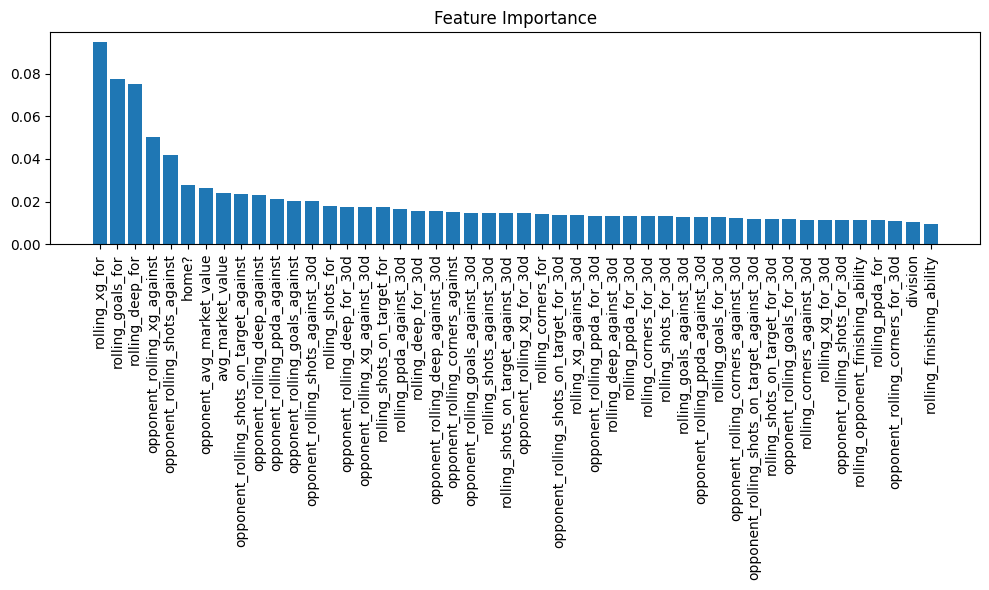

Feature importance ranking:
1. rolling_xg_for: 0.0946
2. rolling_goals_for: 0.0773
3. rolling_deep_for: 0.0754
4. opponent_rolling_xg_against: 0.0504
5. opponent_rolling_shots_against: 0.0417
6. home?: 0.0279
7. opponent_avg_market_value: 0.0265
8. avg_market_value: 0.0239
9. opponent_rolling_shots_on_target_against: 0.0238
10. opponent_rolling_deep_against: 0.0231
11. opponent_rolling_ppda_against: 0.0211
12. opponent_rolling_goals_against: 0.0204
13. opponent_rolling_shots_against_30d: 0.0203
14. rolling_shots_for: 0.0181
15. opponent_rolling_deep_for_30d: 0.0177
16. opponent_rolling_xg_against_30d: 0.0173
17. rolling_shots_on_target_for: 0.0173
18. rolling_ppda_against_30d: 0.0163
19. rolling_deep_for_30d: 0.0156
20. opponent_rolling_deep_against_30d: 0.0154
21. opponent_rolling_corners_against: 0.0150
22. opponent_rolling_goals_against_30d: 0.0149
23. rolling_shots_against_30d: 0.0148
24. rolling_shots_on_target_against_30d: 0.0146
25. opponent_rolling_xg_for_30d: 0.0145
26. rollin

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model is your trained XGBoost model from GridSearchCV
# Get feature importance
importance = model.feature_importances_

# Get feature names (assuming your X_train is a pandas DataFrame)
# If not, you'll need to create a list of feature names
feature_names = X_train.columns

# Sort importance in descending order
indices = np.argsort(importance)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importance in descending order
print("Feature importance ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importance[idx]:.4f}")

In [11]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 150, 175],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [2, 3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 4],
    'gamma': [0, 0.1],
    # Add regularization parameters
    'alpha': [0, 1],  # L1 regularization
    #'lambda': [1, 2]  # L2 regularization
}

# Create base model
xgb_model = xgb.XGBRegressor(
    random_state=26,
    enable_categorical=True
)

X_cv = X[final_df["match_date"] > '2024-08-01']

# Create a TimeSeriesSplit object
# Assuming your data is chronologically ordered
tscv = TimeSeriesSplit(
    n_splits=5,  # 5 temporal folds
    test_size=int(len(X_cv) * 0.2)  # Each validation set is ~20% of data
)

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,  # Use time series cross-validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=4,
    return_train_score=True  # Useful to check for overfitting
)

# Make sure data is sorted chronologically before fitting
# Assuming df has a 'match_date' column
# df = df.sort_values('match_date')
# X_train, y_train should be derived from the sorted dataframe

# Fit grid search
#grid_search.fit(X_train, y_train)

# Best parameters and score
#print("Best parameters:", grid_search.best_params_)
#print("Best CV score:", -grid_search.best_score_)  # Convert back from negative MAE

# Create model with best parameters
#best_model = grid_search.best_estimator_

In [12]:
from sklearn.model_selection import BaseCrossValidator
import pandas as pd
from datetime import timedelta
import numpy as np
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import xgboost as xgb

class WeeklyMatchCV(BaseCrossValidator):
    """Custom CV iterator for weekly football match predictions"""
    
    def __init__(self, dates, start_date, end_date, interval_days=7):
        self.dates = pd.Series(dates)
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.interval_days = interval_days
        
        # Calculate actual number of splits dynamically
        self._n_splits = 0
        current_date = self.start_date
        while current_date < self.end_date:
            next_date = current_date + timedelta(days=interval_days)
            
            # Check if there's data in this week
            if ((self.dates >= current_date) & (self.dates < next_date)).any():
                self._n_splits += 1
                
            current_date = next_date
    
    def split(self, X, y=None, groups=None):
        # Generate the splits based on indices in X
        indices = np.arange(len(X))
        dates = self.dates.iloc[indices] if len(indices) < len(self.dates) else self.dates
        
        current_date = self.start_date
        while current_date < self.end_date:
            next_date = current_date + timedelta(days=self.interval_days)
            
            # Training indices: all data before current_date
            train_idx = indices[dates < current_date]
            
            # Test indices: data between current_date and next_date
            test_idx = indices[(dates >= current_date) & (dates < next_date)]
            
            if len(train_idx) > 0 and len(test_idx) > 0:
                yield train_idx, test_idx
                
            current_date = next_date
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return self._n_splits

# Define search space
search_space = {
    'n_estimators': Integer(50, 300),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(2, 7),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'min_child_weight': Integer(1, 5),
    'gamma': Real(0, 0.5),
    'alpha': Real(0, 2),  # L1 regularization
    'lambda': Real(0, 4)  # L2 regularization
}

# Now use this CV strategy with BayesSearchCV
weekly_cv = WeeklyMatchCV(
    dates=final_df['match_date'],
    start_date="2024-08-01",
    end_date="2025-01-15",  # Your training cutoff
    interval_days=7  # Remove the n_splits parameter
)

# Set up BayesSearchCV with custom CV and MAE scoring
bayes_search = BayesSearchCV(
    estimator=xgb.XGBRegressor(
        objective='count:poisson',
        random_state=26,
        enable_categorical=True
    ),
    search_spaces=search_space,
    cv=weekly_cv,  # Use your custom weekly CV
    n_iter=100,
    scoring='neg_mean_absolute_error',  # Using MAE as requested
    verbose=1,
    n_jobs=4,
    random_state=26,
    return_train_score=True
)

# Fit using the training data
#bayes_search.fit(X_train, y_train)

# Get best parameters and score
#print("Best parameters:", bayes_search.best_params_)
#rint("Best CV score:", -bayes_search.best_score_)

# Create model with best parameters
#best_model = bayes_search.best_estimator_

In [13]:
# Reset index before splitting to avoid duplicate indices
X_with_reset_index = X.reset_index(drop=True)
y_with_reset_index = y.reset_index(drop=True)
final_df_reset = final_df.reset_index(drop=True)

# Now split using the reset data
X_train = X_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
y_train = y_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
X_test = X_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]
y_test = y_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]

# Train and predict as before
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Now creating the results DataFrame is simple
test_results = pd.DataFrame({
    'actual_goals': y_test,
    'predicted_goals': y_pred,
    'error': y_test - y_pred,
    'abs_error': abs(y_test - y_pred)
})

# Add match information - this will align correctly since indices are reset
test_results['match_date'] = final_df_reset.loc[y_test.index, 'match_date']
test_results['team'] = final_df_reset.loc[y_test.index, 'team']
test_results['opponent_team'] = final_df_reset.loc[y_test.index, 'opponent_team']
test_results['home'] = final_df_reset.loc[y_test.index, 'home?']
test_results['division'] = final_df_reset.loc[y_test.index, 'division']

# Sort by date
test_results = test_results.sort_values('match_date')

test_results[test_results["division"] == 'Premier League']

,actual_goals,predicted_goals,error,abs_error,match_date,team,opponent_team,home,division
124,2,2.368433,-0.368433,0.368433,2025-01-15,Arsenal,Tottenham,1,Premier League
960,2,1.659305,0.340695,0.340695,2025-01-15,Crystal Palace,Leicester,0,Premier League
1091,0,1.095870,-1.095870,1.095870,2025-01-15,Everton,Aston Villa,1,Premier League
2355,1,1.156453,-0.156453,0.156453,2025-01-15,Tottenham,Arsenal,0,Premier League
2649,0,0.990081,-0.990081,0.990081,2025-01-15,Wolves,Newcastle,0,Premier League
...,...,...,...,...,...,...,...,...,...
1395,0,1.091152,-1.091152,1.091152,2025-03-16,Leicester,Man United,1,Premier League
1205,2,1.234896,0.765104,0.765104,2025-03-16,Fulham,Tottenham,1,Premier League
835,0,1.271678,-1.271678,1.271678,2025-03-16,Chelsea,Arsenal,0,Premier League
132,1,1.798291,-0.798291,0.798291,2025-03-16,Arsenal,Chelsea,1,Premier League


In [14]:
def predict_match(trained_model, X_test, home_team, away_team, division="Premier League", match_date=None, debug=True):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Get season from match date (assuming season starts in July)
    season = match_date.year if match_date.month > 6 else match_date.year - 1
    
    # Define window sizes and decay rates
    windows_and_decays = [(365, 0.0065), (30, 0.001)]
    
    # Calculate metrics using calc_team_metrics_multi_window function for both teams
    home_metrics = calc_team_metrics_multi_window(home_team, match_date, windows_and_decays=windows_and_decays)
    away_metrics = calc_team_metrics_multi_window(away_team, match_date, windows_and_decays=windows_and_decays)
    
    # Get market values
    home_market_value = df[df['team'] == home_team].iloc[-1]['avg_market_value'] if len(df[df['team'] == home_team]) > 0 else np.nan
    away_market_value = df[df['team'] == away_team].iloc[-1]['avg_market_value'] if len(df[df['team'] == away_team]) > 0 else np.nan
    
    # Calculate finishing ability (goals - xG) for both windows
    home_finishing_ability = home_metrics['rolling_goals_for'] - home_metrics['rolling_xg_for']
    away_finishing_ability = away_metrics['rolling_goals_for'] - away_metrics['rolling_xg_for']
    
    # Calculate opponent finishing ability for both windows
    home_opponent_finishing_ability = away_metrics['rolling_goals_against'] - away_metrics['rolling_xg_against']
    away_opponent_finishing_ability = home_metrics['rolling_goals_against'] - home_metrics['rolling_xg_against']
    
    # Define feature columns in EXACTLY the same order as training data
    feature_cols = ["division", "home?", "avg_market_value", "opponent_avg_market_value", 
                   "rolling_finishing_ability", "rolling_opponent_finishing_ability",
                   "rolling_goals_for", "rolling_xg_for", "rolling_shots_for", 
                   "rolling_shots_on_target_for", "rolling_corners_for", "rolling_deep_for", "rolling_ppda_for", 
                   'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 
                   'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 
                   'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 
                   'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 
                   "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against", 
                   "opponent_rolling_shots_on_target_against", "opponent_rolling_corners_against", 
                   "opponent_rolling_deep_against", "opponent_rolling_ppda_against", 
                   'opponent_rolling_goals_for_30d', 'opponent_rolling_goals_against_30d', 'opponent_rolling_xg_for_30d', 
                   'opponent_rolling_xg_against_30d', 'opponent_rolling_shots_for_30d', 'opponent_rolling_shots_against_30d', 
                   'opponent_rolling_shots_on_target_for_30d', 'opponent_rolling_shots_on_target_against_30d', 
                   'opponent_rolling_corners_for_30d', 'opponent_rolling_corners_against_30d', 
                   'opponent_rolling_deep_for_30d', 'opponent_rolling_deep_against_30d', 
                   'opponent_rolling_ppda_for_30d', 'opponent_rolling_ppda_against_30d']
    
    # Create data dictionaries for home team
    home_data = {
        'division': division,
        'home?': 1,
        'avg_market_value': home_market_value,
        'opponent_avg_market_value': away_market_value,
        'rolling_finishing_ability': home_finishing_ability,
        'rolling_opponent_finishing_ability': home_opponent_finishing_ability,
        
        # 365-day metrics
        'rolling_goals_for': home_metrics['rolling_goals_for'],
        'rolling_xg_for': home_metrics['rolling_xg_for'],
        'rolling_shots_for': home_metrics['rolling_shots_for'],
        'rolling_shots_on_target_for': home_metrics['rolling_shots_on_target_for'],
        'rolling_corners_for': home_metrics['rolling_corners_for'],
        'rolling_deep_for': home_metrics['rolling_deep_for'],
        'rolling_ppda_for': home_metrics['rolling_ppda_for'],
        
        # 30-day team metrics
        'rolling_goals_for_30d': home_metrics['rolling_goals_for_30d'],
        'rolling_goals_against_30d': home_metrics['rolling_goals_against_30d'],
        'rolling_xg_for_30d': home_metrics['rolling_xg_for_30d'],
        'rolling_xg_against_30d': home_metrics['rolling_xg_against_30d'],
        'rolling_shots_for_30d': home_metrics['rolling_shots_for_30d'],
        'rolling_shots_against_30d': home_metrics['rolling_shots_against_30d'],
        'rolling_shots_on_target_for_30d': home_metrics['rolling_shots_on_target_for_30d'],
        'rolling_shots_on_target_against_30d': home_metrics['rolling_shots_on_target_against_30d'],
        'rolling_corners_for_30d': home_metrics['rolling_corners_for_30d'],
        'rolling_corners_against_30d': home_metrics['rolling_corners_against_30d'],
        'rolling_deep_for_30d': home_metrics['rolling_deep_for_30d'],
        'rolling_deep_against_30d': home_metrics['rolling_deep_against_30d'],
        'rolling_ppda_for_30d': home_metrics['rolling_ppda_for_30d'],
        'rolling_ppda_against_30d': home_metrics['rolling_ppda_against_30d'],
        
        # 365-day opponent metrics
        'opponent_rolling_goals_against': away_metrics['rolling_goals_against'],
        'opponent_rolling_xg_against': away_metrics['rolling_xg_against'],
        'opponent_rolling_shots_against': away_metrics['rolling_shots_against'],
        'opponent_rolling_shots_on_target_against': away_metrics['rolling_shots_on_target_against'],
        'opponent_rolling_corners_against': away_metrics['rolling_corners_against'],
        'opponent_rolling_deep_against': away_metrics['rolling_deep_against'],
        'opponent_rolling_ppda_against': away_metrics['rolling_ppda_against'],
        
        # 30-day opponent metrics
        'opponent_rolling_goals_for_30d': away_metrics['rolling_goals_for_30d'],
        'opponent_rolling_goals_against_30d': away_metrics['rolling_goals_against_30d'],
        'opponent_rolling_xg_for_30d': away_metrics['rolling_xg_for_30d'],
        'opponent_rolling_xg_against_30d': away_metrics['rolling_xg_against_30d'],
        'opponent_rolling_shots_for_30d': away_metrics['rolling_shots_for_30d'],
        'opponent_rolling_shots_against_30d': away_metrics['rolling_shots_against_30d'],
        'opponent_rolling_shots_on_target_for_30d': away_metrics['rolling_shots_on_target_for_30d'],
        'opponent_rolling_shots_on_target_against_30d': away_metrics['rolling_shots_on_target_against_30d'],
        'opponent_rolling_corners_for_30d': away_metrics['rolling_corners_for_30d'],
        'opponent_rolling_corners_against_30d': away_metrics['rolling_corners_against_30d'],
        'opponent_rolling_deep_for_30d': away_metrics['rolling_deep_for_30d'],
        'opponent_rolling_deep_against_30d': away_metrics['rolling_deep_against_30d'],
        'opponent_rolling_ppda_for_30d': away_metrics['rolling_ppda_for_30d'],
        'opponent_rolling_ppda_against_30d': away_metrics['rolling_ppda_against_30d']
    }
    
    # Create data dictionary for away team
    away_data = {
        'division': division,
        'home?': 0,
        'avg_market_value': away_market_value,
        'opponent_avg_market_value': home_market_value,
        'rolling_finishing_ability': away_finishing_ability,
        'rolling_opponent_finishing_ability': away_opponent_finishing_ability,
        
        # 365-day metrics
        'rolling_goals_for': away_metrics['rolling_goals_for'],
        'rolling_xg_for': away_metrics['rolling_xg_for'],
        'rolling_shots_for': away_metrics['rolling_shots_for'],
        'rolling_shots_on_target_for': away_metrics['rolling_shots_on_target_for'],
        'rolling_corners_for': away_metrics['rolling_corners_for'],
        'rolling_deep_for': away_metrics['rolling_deep_for'],
        'rolling_ppda_for': away_metrics['rolling_ppda_for'],
        
        # 30-day team metrics
        'rolling_goals_for_30d': away_metrics['rolling_goals_for_30d'],
        'rolling_goals_against_30d': away_metrics['rolling_goals_against_30d'],
        'rolling_xg_for_30d': away_metrics['rolling_xg_for_30d'],
        'rolling_xg_against_30d': away_metrics['rolling_xg_against_30d'],
        'rolling_shots_for_30d': away_metrics['rolling_shots_for_30d'],
        'rolling_shots_against_30d': away_metrics['rolling_shots_against_30d'],
        'rolling_shots_on_target_for_30d': away_metrics['rolling_shots_on_target_for_30d'],
        'rolling_shots_on_target_against_30d': away_metrics['rolling_shots_on_target_against_30d'],
        'rolling_corners_for_30d': away_metrics['rolling_corners_for_30d'],
        'rolling_corners_against_30d': away_metrics['rolling_corners_against_30d'],
        'rolling_deep_for_30d': away_metrics['rolling_deep_for_30d'],
        'rolling_deep_against_30d': away_metrics['rolling_deep_against_30d'],
        'rolling_ppda_for_30d': away_metrics['rolling_ppda_for_30d'],
        'rolling_ppda_against_30d': away_metrics['rolling_ppda_against_30d'],
        
        # 365-day opponent metrics
        'opponent_rolling_goals_against': home_metrics['rolling_goals_against'],
        'opponent_rolling_xg_against': home_metrics['rolling_xg_against'],
        'opponent_rolling_shots_against': home_metrics['rolling_shots_against'],
        'opponent_rolling_shots_on_target_against': home_metrics['rolling_shots_on_target_against'],
        'opponent_rolling_corners_against': home_metrics['rolling_corners_against'],
        'opponent_rolling_deep_against': home_metrics['rolling_deep_against'],
        'opponent_rolling_ppda_against': home_metrics['rolling_ppda_against'],
        
        # 30-day opponent metrics
        'opponent_rolling_goals_for_30d': home_metrics['rolling_goals_for_30d'],
        'opponent_rolling_goals_against_30d': home_metrics['rolling_goals_against_30d'],
        'opponent_rolling_xg_for_30d': home_metrics['rolling_xg_for_30d'],
        'opponent_rolling_xg_against_30d': home_metrics['rolling_xg_against_30d'],
        'opponent_rolling_shots_for_30d': home_metrics['rolling_shots_for_30d'],
        'opponent_rolling_shots_against_30d': home_metrics['rolling_shots_against_30d'],
        'opponent_rolling_shots_on_target_for_30d': home_metrics['rolling_shots_on_target_for_30d'],
        'opponent_rolling_shots_on_target_against_30d': home_metrics['rolling_shots_on_target_against_30d'],
        'opponent_rolling_corners_for_30d': home_metrics['rolling_corners_for_30d'],
        'opponent_rolling_corners_against_30d': home_metrics['rolling_corners_against_30d'],
        'opponent_rolling_deep_for_30d': home_metrics['rolling_deep_for_30d'],
        'opponent_rolling_deep_against_30d': home_metrics['rolling_deep_against_30d'],
        'opponent_rolling_ppda_for_30d': home_metrics['rolling_ppda_for_30d'],
        'opponent_rolling_ppda_against_30d': home_metrics['rolling_ppda_against_30d']
    }
    
    # Create DataFrame with only the features in the correct order
    home_features = pd.DataFrame({k: [v] for k, v in home_data.items()})[feature_cols]
    away_features = pd.DataFrame({k: [v] for k, v in away_data.items()})[feature_cols]
    
    # Apply categorical encoding to division column
    for col in ["division"]:
        home_features[col] = pd.Categorical(
            home_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
        away_features[col] = pd.Categorical(
            away_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
    
    # Print features for debugging
    if debug:
        print("Home team features:")
        print(home_features)
        print("\nAway team features:")
        print(away_features)
    
    # Make predictions
    home_goals_pred = trained_model.predict(home_features)[0]
    away_goals_pred = trained_model.predict(away_features)[0]
    
    # Calculate goal distributions using Poisson
    max_goals = 10
    home_goals_pmf = np.array([poisson.pmf(i, home_goals_pred) for i in range(max_goals)])
    away_goals_pmf = np.array([poisson.pmf(i, away_goals_pred) for i in range(max_goals)])
    
    # Create a matrix of probabilities for each score combination
    score_matrix = np.outer(home_goals_pmf, away_goals_pmf)
    
    # Calculate outcome probabilities
    home_win_prob = np.sum(np.tril(score_matrix, -1))
    draw_prob = np.sum(np.diag(score_matrix))
    away_win_prob = np.sum(np.triu(score_matrix, 1))
    
    # Find most likely scoreline
    max_score_idx = np.unravel_index(score_matrix.argmax(), score_matrix.shape)
    most_likely_score = f"{max_score_idx[0]}-{max_score_idx[1]}"
    
    # Return results
    return {
        'home_team': home_team,
        'away_team': away_team,
        'division': division,
        'match_date': match_date,
        'predicted_home_goals': round(home_goals_pred, 2),
        'predicted_away_goals': round(away_goals_pred, 2),
        'home_win_probability': round(home_win_prob * 100, 2),
        'draw_probability': round(draw_prob * 100, 2),
        'away_win_probability': round(away_win_prob * 100, 2),
        'most_likely_score': most_likely_score,
        'expected_total_goals': round(home_goals_pred + away_goals_pred, 2)
    }

In [15]:
# Example usage
prediction = predict_match(
    trained_model=model,  # Your trained XGBoost model
    X_test=X_test,        # Your test dataset (needed for categorical encodings)
    home_team="Arsenal",
    away_team="Fulham",
    division="Premier League",
    match_date="2025-03-22"  # Optional - defaults to current date if not provided
)

# Print the prediction results
print(prediction)

# To access specific values
print(f"Predicted score: {prediction['predicted_home_goals']:.2f} - {prediction['predicted_away_goals']:.2f}")
print(f"Most likely result: {prediction['most_likely_score']}")
print(f"Win probabilities: Home {prediction['home_win_probability']}%, Draw {prediction['draw_probability']}%, Away {prediction['away_win_probability']}%")

Home team features:
         division  home?  avg_market_value  opponent_avg_market_value  \
0  Premier League      1          50869565                   12704545   

   rolling_finishing_ability  rolling_opponent_finishing_ability  \
0                  -0.050639                            0.076531   

   rolling_goals_for  rolling_xg_for  rolling_shots_for  \
0           1.906931        1.957569          14.397544   

   rolling_shots_on_target_for  ...  opponent_rolling_shots_for_30d  \
0                     4.926351  ...                       12.765234   

   opponent_rolling_shots_against_30d  \
0                           11.404582   

   opponent_rolling_shots_on_target_for_30d  \
0                                  3.983876   

   opponent_rolling_shots_on_target_against_30d  \
0                                      4.003369   

   opponent_rolling_corners_for_30d  opponent_rolling_corners_against_30d  \
0                          6.595573                              5.195691   

In [16]:
def calculate_team_strength(trained_model, X_test, team, match_date=None, division="Premier League"):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Calculate team metrics
    team_metrics = calc_team_metrics_up_to_date(team, match_date)
    
    # Get market value for the team
    team_market_value = df[df['team'] == team].iloc[-1]['avg_market_value'] if len(df[df['team'] == team]) > 0 else np.nan
    
    # Calculate team's finishing ability
    team_finishing_ability = team_metrics['rolling_goals_for'] - team_metrics['rolling_xg_for']
    
    # Calculate team's opponent finishing ability
    team_opponent_finishing_ability = team_metrics['rolling_goals_against'] - team_metrics['rolling_xg_against']
    
    # Define current Premier League teams for 2024-2025 season
    current_prem_teams = final_df[(final_df['division'] == division) & (final_df['season'] == 20242025)]['team'].unique().tolist()
    
    # Filter to only current Premier League teams
    all_teams = [t for t in final_df['team'].unique().tolist() if t in current_prem_teams]
    
    # Expanded average metrics
    avg_metrics = {
        'rolling_goals_for': 0,
        'rolling_goals_against': 0,
        'rolling_xg_for': 0,
        'rolling_xg_against': 0,
        'rolling_shots_for': 0,
        'rolling_shots_against': 0,
        'rolling_shots_on_target_for': 0,
        'rolling_shots_on_target_against': 0,
        'rolling_corners_for': 0,
        'rolling_corners_against': 0,
        'rolling_deep_for': 0,
        'rolling_deep_against': 0,
        'rolling_ppda_for': 0,
        'rolling_ppda_against': 0,
        'avg_market_value': 0,
        'rolling_finishing_ability': 0,
        'rolling_opponent_finishing_ability': 0
    }
    
    valid_team_count = 0
    for t in all_teams:
        try:
            t_metrics = calc_team_metrics_up_to_date(t, match_date)
            t_market_value = df[df['team'] == t].iloc[-1]['avg_market_value'] if len(df[df['team'] == t]) > 0 else np.nan
            t_finishing_ability = t_metrics['rolling_goals_for'] - t_metrics['rolling_xg_for']
            t_opponent_finishing_ability = t_metrics['rolling_goals_against'] - t_metrics['rolling_xg_against']
            
            # Only include teams with valid metrics
            if not np.isnan(t_metrics['rolling_goals_for']):
                for key in t_metrics:
                    if key in avg_metrics:
                        avg_metrics[key] += t_metrics[key]
                
                # Add finishing ability to averages
                avg_metrics['rolling_finishing_ability'] += t_finishing_ability
                avg_metrics['rolling_opponent_finishing_ability'] += t_opponent_finishing_ability
                
                if not np.isnan(t_market_value):
                    avg_metrics['avg_market_value'] += t_market_value
                
                valid_team_count += 1
        except Exception as e:
            print(f"Error getting metrics for {t}: {e}")
            continue
    
    # Calculate averages
    for key in avg_metrics:
        if valid_team_count > 0:
            avg_metrics[key] /= valid_team_count
    
    # Create a fictional "average" team name for comparison
    #avg_team_name = X_test['team'].cat.categories[0]  # Use the first category as fallback
    
    # Create features for team vs average (no home advantage)
    team_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'avg_market_value': [team_market_value],
        'opponent_avg_market_value': [avg_metrics['avg_market_value']],
        'rolling_finishing_ability': [team_finishing_ability],
        'rolling_opponent_finishing_ability': [team_opponent_finishing_ability],
        #'team': [team],
        #'opponent_team': [avg_team_name],
        'rolling_goals_for': [team_metrics['rolling_goals_for']],
        'rolling_xg_for': [team_metrics['rolling_xg_for']],
        'rolling_shots_for': [team_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [team_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [team_metrics['rolling_corners_for']],
        'rolling_deep_for': [team_metrics['rolling_deep_for']],
        'rolling_ppda_for': [team_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [avg_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [avg_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [avg_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [avg_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [avg_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [avg_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [avg_metrics['rolling_ppda_against']]
    })
    
    avg_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'avg_market_value': [avg_metrics['avg_market_value']],
        'opponent_avg_market_value': [team_market_value],
        'rolling_finishing_ability': [avg_metrics['rolling_finishing_ability']],
        'rolling_opponent_finishing_ability': [avg_metrics['rolling_opponent_finishing_ability']],
        #'team': [avg_team_name],
        #'opponent_team': [team],
        'rolling_goals_for': [avg_metrics['rolling_goals_for']],
        'rolling_xg_for': [avg_metrics['rolling_xg_for']],
        'rolling_shots_for': [avg_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [avg_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [avg_metrics['rolling_corners_for']],
        'rolling_deep_for': [avg_metrics['rolling_deep_for']],
        'rolling_ppda_for': [avg_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [team_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [team_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [team_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [team_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [team_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [team_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [team_metrics['rolling_ppda_against']]
    })
    
    # Ensure all categorical columns have the correct type
    cat_cols = ["division"]
    
    for col in cat_cols:
        if col in X_test.columns and hasattr(X_test[col], 'cat'):
            # Convert to categorical with the same categories as X_test
            team_features[col] = pd.Categorical(
                team_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
            
            avg_features[col] = pd.Categorical(
                avg_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
    
    # Make predictions
    team_goals_pred = trained_model.predict(team_features)[0]
    avg_goals_pred = trained_model.predict(avg_features)[0]
    
    # Goal difference against average team
    goal_diff = team_goals_pred - avg_goals_pred
    
    return {
        'team': team,
        'predicted_goals_for': round(team_goals_pred, 2),
        'predicted_goals_against': round(avg_goals_pred, 2),
        'predicted_goal_diff': round(goal_diff, 2),
        'market_value': team_market_value,
        'rolling_xg_for': round(team_metrics['rolling_xg_for'], 2),
        'rolling_xg_against': round(team_metrics['rolling_xg_against'], 2),
        'xg_difference': round(team_metrics['rolling_xg_for'] - team_metrics['rolling_xg_against'], 2),
        'finishing_ability': round(team_finishing_ability, 2),
        'opponent_finishing_ability': round(team_opponent_finishing_ability, 2)
    }


def generate_team_strength_table(trained_model, X_test, final_df, match_date=None, division="Premier League"):
    # Filter teams that are in the specified division in final_df
    premier_league_teams = final_df[(final_df['division'] == division) & (final_df['season'] == 20242025)]['team'].unique().tolist()
    
    # Calculate strength for each team
    team_strengths = []
    for team in premier_league_teams:
        try:
            strength = calculate_team_strength(
                trained_model=trained_model,
                X_test=X_test,
                team=team,
                match_date=match_date,
                division=division
            )
            team_strengths.append(strength)
        except Exception as e:
            print(f"Error calculating strength for {team}: {e}")
            continue
    
    # Create DataFrame from results
    strength_df = pd.DataFrame(team_strengths)
    
    # Check if DataFrame is empty
    if strength_df.empty:
        print("No teams found matching the criteria.")
        return pd.DataFrame(columns=['rank', 'team', 'predicted_goals_for', 
                                   'predicted_goals_against', 'predicted_goal_diff', 
                                   'market_value', 'rolling_xg_for', 
                                   'rolling_xg_against', 'xg_difference', 'finishing_ability', 'opponent_finishing_ability'])
    
    # Sort by predicted goal difference (descending)
    strength_df = strength_df.sort_values('predicted_goal_diff', ascending=False)
    
    # Add rank column
    strength_df['rank'] = range(1, len(strength_df) + 1)
    
    # Reorder columns
    strength_df = strength_df[['rank', 'team', 'predicted_goals_for', 'predicted_goals_against', 
                              'predicted_goal_diff', 'market_value', 'rolling_xg_for', 
                              'rolling_xg_against', 'xg_difference', 'finishing_ability', 'opponent_finishing_ability']]
    
    return strength_df

# Now call this function to get all teams
all_teams_strength = generate_team_strength_table(
    trained_model=model,
    X_test=X_test,
    final_df=final_df,
    match_date='2025-03-20'
)

# Display the results
print(all_teams_strength[["team", "predicted_goals_for", "predicted_goals_against", "predicted_goal_diff"]].sort_values(by="predicted_goal_diff", ascending=False))


Error calculating strength for Arsenal: feature_names mismatch: ['division', 'home?', 'avg_market_value', 'opponent_avg_market_value', 'rolling_finishing_ability', 'rolling_opponent_finishing_ability', 'rolling_goals_for', 'rolling_xg_for', 'rolling_shots_for', 'rolling_shots_on_target_for', 'rolling_corners_for', 'rolling_deep_for', 'rolling_ppda_for', 'rolling_goals_for_30d', 'rolling_goals_against_30d', 'rolling_xg_for_30d', 'rolling_xg_against_30d', 'rolling_shots_for_30d', 'rolling_shots_against_30d', 'rolling_shots_on_target_for_30d', 'rolling_shots_on_target_against_30d', 'rolling_corners_for_30d', 'rolling_corners_against_30d', 'rolling_deep_for_30d', 'rolling_deep_against_30d', 'rolling_ppda_for_30d', 'rolling_ppda_against_30d', 'opponent_rolling_goals_against', 'opponent_rolling_xg_against', 'opponent_rolling_shots_against', 'opponent_rolling_shots_on_target_against', 'opponent_rolling_corners_against', 'opponent_rolling_deep_against', 'opponent_rolling_ppda_against', 'oppone


Weekly Evaluation Complete
Overall MAE: 0.9286
Total matches evaluated: 578


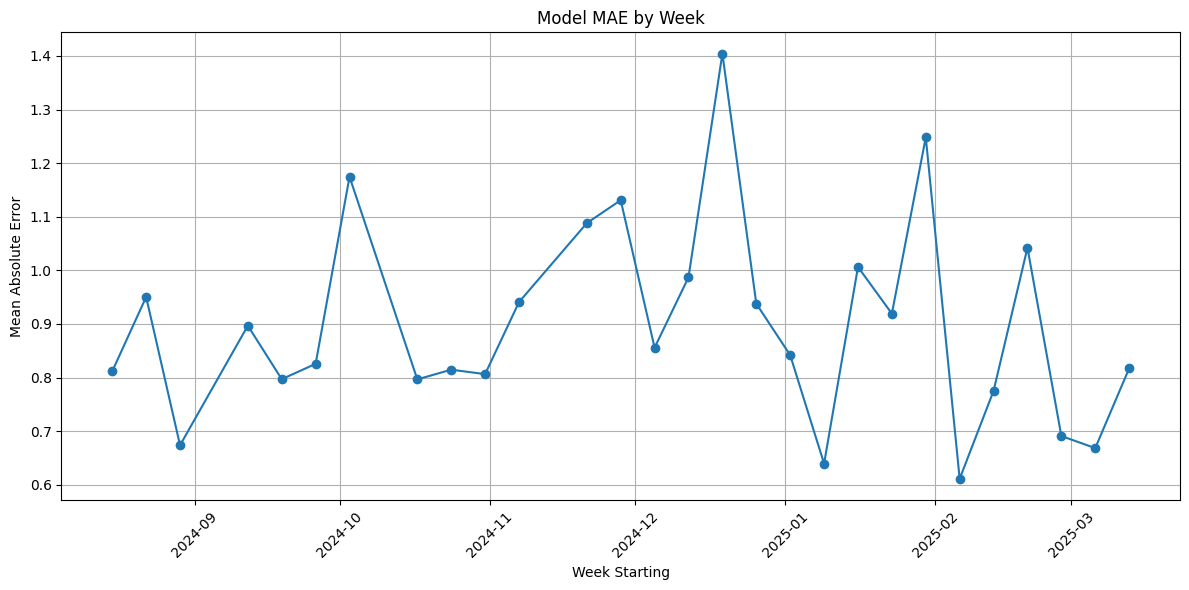


Summary Statistics:
Average Weekly MAE: 0.8983
Best Week MAE: 0.6112
Worst Week MAE: 1.4044


In [17]:
def evaluate_weekly(final_df, start_date, end_date, feature_cols, target_col="goals", 
                    promoted_teams=None, interval_days=7, verbose=True):
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    import xgboost as xgb
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    # Convert dates to datetime objects if they're strings
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Prepare results storage
    weekly_results = []
    all_predictions = []
    
    # Convert categorical columns to category type if needed
    cat_cols = ["division"] #, "team", "opponent_team"
    X = final_df[feature_cols].copy()
    for col in cat_cols:
        if col in X.columns:
            X[col] = X[col].astype('category')
    

    # Loop through each week
    week_count = 0
    while current_date < end_date:
        week_count += 1
        next_date = current_date + timedelta(days=interval_days)
        
        if verbose:
            print(f"\nEvaluating week {week_count}: {current_date.date()} to {next_date.date()}")
        
        # Define training and test sets
        train_mask = final_df['match_date'] < current_date
        test_mask = (final_df['match_date'] >= current_date) & (final_df['match_date'] < next_date)
        
        # Skip if no test data for this week
        if test_mask.sum() == 0:
            if verbose:
                print(f"No matches found between {current_date.date()} and {next_date.date()}, skipping.")
            current_date = next_date
            continue
            
        # Create training and test sets
        X_train = X[train_mask]
        y_train = final_df.loc[train_mask, target_col]
        X_test = X[test_mask]
        y_test = final_df.loc[test_mask, target_col]
        
        # Skip if training data is insufficient
        if len(X_train) < 50:  # Arbitrary minimum threshold
            if verbose:
                print(f"Insufficient training data ({len(X_train)} samples), skipping.")
            current_date = next_date
            continue
        
        if verbose:
            print(f"Training on {len(X_train)} matches, testing on {len(X_test)} matches")
            
        # Train model
        model = xgb.XGBRegressor(objective='count:poisson',**model_params, enable_categorical=True)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store weekly results
        weekly_results.append({
            'week_starting': current_date,
            'week_ending': next_date - timedelta(days=1),  # Subtract 1 day for inclusive range
            'matches_tested': len(X_test),
            'matches_trained': len(X_train),
            'mae': mae,
            'rmse': rmse
        })
        
        # Store detailed predictions for further analysis
        match_predictions = pd.DataFrame({
            'match_date': final_df.loc[test_mask, 'match_date'],
            'team': final_df.loc[test_mask, 'team'],
            'opponent_team': final_df.loc[test_mask, 'opponent_team'],
            'home': final_df.loc[test_mask, 'home?'],
            'division': final_df.loc[test_mask, 'division'],
            'actual_goals': y_test.values,
            'predicted_goals': y_pred,
            'error': y_test.values - y_pred,
            'abs_error': np.abs(y_test.values - y_pred),
            'eval_week': week_count
        })
        all_predictions.append(match_predictions)
        
        #if verbose:
        #    print(f"Week {week_count} MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        # Move to next week
        current_date = next_date
    
    # Create final results DataFrame
    results_df = pd.DataFrame(weekly_results)
    all_predictions_df = pd.concat(all_predictions, ignore_index=True) if all_predictions else pd.DataFrame()
    

    print("\nWeekly Evaluation Complete")
    print(f"Overall MAE: {all_predictions_df['abs_error'].mean():.4f}")
    print(f"Total matches evaluated: {len(all_predictions_df)}")
        
    return results_df, all_predictions_df

# Set evaluation period
start_date = "2024-08-01"  # Start after a few games have been played
end_date = "2025-03-17"    # End with the most recent data

# Run weekly evaluation
weekly_results, all_predictions = evaluate_weekly(
    final_df, 
    start_date=start_date,
    end_date=end_date,
    feature_cols=feature_cols,
    promoted_teams=["Ipswich", "Leicester", "Southampton"],
    verbose=False
)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(weekly_results['week_starting'], weekly_results['mae'], marker='o')
plt.title('Model MAE by Week')
plt.xlabel('Week Starting')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average Weekly MAE: {weekly_results['mae'].mean():.4f}")
print(f"Best Week MAE: {weekly_results['mae'].min():.4f}")
print(f"Worst Week MAE: {weekly_results['mae'].max():.4f}")

all_predictions.to_csv("preds.csv")